# Data Mining II Project 
***
#### University of Pisa - Gabriele Leone, Federica Trevisan

# Alternative Classification methods
Test different classification methods over a simple classification problem.

## Dataset
The UCI Abalone dataset, containing various features of abalones, including the age to be inferred by the number or rings. 
https://archive.ics.uci.edu/ml/datasets/Abalone

- Number of Instances: 4177  
- Number of Attributes: 8  
- Missing Attribute Values: None

| Name | Data Type | Measurement Unit | Description |
|---| --- | --- |---|
| Sex | nominal | - | M, F, and I (infant)        |
| Length | continuous | mm | Longest shell measurement   |
| Diameter | continuous | mm | perpendicular to length     |
| Height | continuous | mm | with meat in shell          |
| Whole weight | continuous | grams | whole abalone               |
| Shucked weight | continuous | grams | weight of meat              |
| Viscera weight | continuous | grams | gut weight (after bleeding) |
| Shell weight | continuous | grams | after being dried           |
| Rings | integer | -- | +1.5 gives the age in years |

## Objective 
- discard the “Infant” abalones; 
- discretize the attribute “Number of rings” into 2 classes; 
- try at least 3 different classification methods (among those discussed in DM2, including ensemble methods) on the resulting dataset, using the discretized n. of rings as class, and evaluating them with cross-validation.

Predicting the age of abalone from physical measurements.  The age of
   abalone is determined by cutting the shell through the cone, staining it,
   and counting the number of rings through a microscope -- a boring and
   time-consuming task.  Other measurements, which are easier to obtain, are
   used to predict the age.  Further information, such as weather patterns
   and location (hence food availability) may be required to solve the problem.

   From the original data examples with missing values were removed (the
   majority having the predicted value missing), and the ranges of the
   continuous values have been scaled for use with an ANN (by dividing by 200).

   Data comes from an original (non-machine-learning) study

In [105]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import time
import seaborn as sns
from scipy.stats import randint as sp_randint
from sklearn import tree
from sklearn import metrics
from sklearn import neighbors
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB

In [2]:
abalone_data = pd.read_csv("abalone_dataset.csv")
abalone_data.dtypes

sex                object
length            float64
diameter          float64
height            float64
weight_whole      float64
weight_shucked    float64
weight_viscera    float64
weight_shell      float64
rings               int64
dtype: object

## Data Understanding

In [3]:
abalone_data.head()

,sex,length,diameter,height,weight_whole,weight_shucked,weight_viscera,weight_shell,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [4]:
abalone_data.tail()

,sex,length,diameter,height,weight_whole,weight_shucked,weight_viscera,weight_shell,rings
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10
4176,M,0.710,0.555,0.195,1.9485,0.9455,0.3765,0.4950,12


In [5]:
abalone_data.describe()

,length,diameter,height,weight_whole,weight_shucked,weight_viscera,weight_shell,rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [6]:
abalone_data.corr()

,length,diameter,height,weight_whole,weight_shucked,weight_viscera,weight_shell,rings
length,1.000000,0.986812,0.827554,0.925261,0.897914,0.903018,0.897706,0.556720
diameter,0.986812,1.000000,0.833684,0.925452,0.893162,0.899724,0.905330,0.574660
height,0.827554,0.833684,1.000000,0.819221,0.774972,0.798319,0.817338,0.557467
weight_whole,0.925261,0.925452,0.819221,1.000000,0.969405,0.966375,0.955355,0.540390
weight_shucked,0.897914,0.893162,0.774972,0.969405,1.000000,0.931961,0.882617,0.420884
weight_viscera,0.903018,0.899724,0.798319,0.966375,0.931961,1.000000,0.907656,0.503819
weight_shell,0.897706,0.905330,0.817338,0.955355,0.882617,0.907656,1.000000,0.627574
rings,0.556720,0.574660,0.557467,0.540390,0.420884,0.503819,0.627574,1.000000


## Pairwise correlation

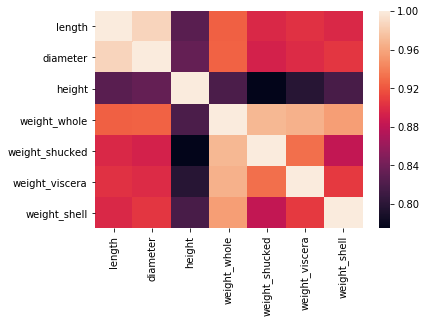

In [7]:
# load the Abalone dataset, dropping the rings column
abalone_data_no_rings = abalone_data.drop('rings', axis = 1)
# calculate the correlation matrix
corr = abalone_data_no_rings.corr()
# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
plt.show()

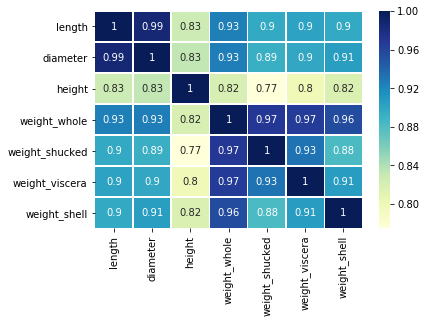

In [8]:
# load the Abalone dataset, dropping the rings column
abalone_data_no_rings = abalone_data.drop('rings', axis = 1)
# calculate the correlation matrix
corr = abalone_data_no_rings.corr()
# plot the heatmap
correlation = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap="YlGnBu", 
            linewidths=.5, annot=True,)
plt.show()
fig = correlation.get_figure()
fig.tight_layout()
fig.savefig("correlation.png")

In [9]:
abalone_data['sex'].unique()

array(['M', 'F', 'I'], dtype=object)

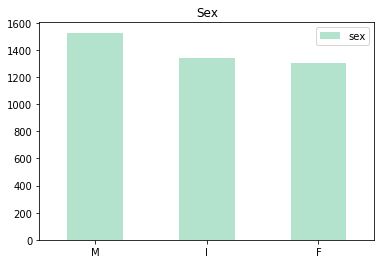

In [10]:
abalone_data['sex'].value_counts().plot(kind='bar', title='Sex', legend=True, style=None, colormap="Pastel2")
plt.xticks(rotation=0)
plt.show()

# Discard the Infants

In [11]:
abalone_data_mf = abalone_data[abalone_data.sex != 'I']

In [12]:
abalone_data_mf['sex'].unique()

array(['M', 'F'], dtype=object)

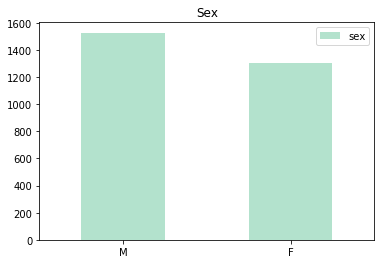

In [13]:
abalone_data_mf['sex'].value_counts().plot(kind='bar', title='Sex', legend=True, style=None, colormap="Pastel2")
plt.xticks(rotation=0)
plt.show()

In [14]:
abalone_data_mf['sex'].value_counts()

M    1528
F    1307
Name: sex, dtype: int64

In [15]:
# discard sex column
abalone_data_mf = abalone_data_mf.drop('sex', axis=1)

In [16]:
abalone_data_mf.head()

,length,diameter,height,weight_whole,weight_shucked,weight_viscera,weight_shell,rings
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
6,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,20


In [17]:
abalone_data_mf.describe()

,length,diameter,height,weight_whole,weight_shucked,weight_viscera,weight_shell,rings
count,2835.000000,2835.000000,2835.000000,2835.000000,2835.000000,2835.000000,2835.000000,2835.000000
mean,0.569552,0.446407,0.154437,1.016849,0.439051,0.222526,0.291208,10.900882
std,0.095821,0.078850,0.037421,0.453217,0.212193,0.101880,0.128835,3.069252
min,0.155000,0.110000,0.015000,0.015500,0.006500,0.003000,0.005000,3.000000
25%,0.515000,0.400000,0.135000,0.701250,0.287000,0.152000,0.202500,9.000000
50%,0.585000,0.460000,0.155000,1.003000,0.431500,0.217000,0.285000,10.000000
75%,0.635000,0.500000,0.175000,1.289500,0.568750,0.287500,0.365000,12.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


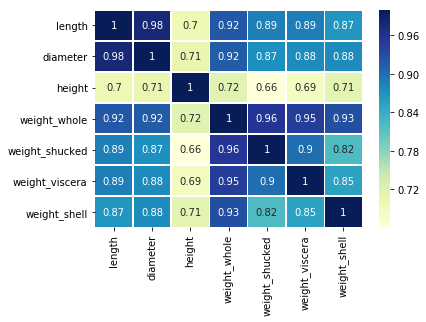

In [18]:
# load the Abalone dataset, dropping the rings column
abalone_data_no_rings_mf = abalone_data_mf.drop('rings', axis = 1)
# calculate the correlation matrix
corr_mf = abalone_data_no_rings_mf.corr()
# plot the heatmap
correlation_mf = sns.heatmap(corr_mf, xticklabels=corr_mf.columns, yticklabels=corr_mf.columns, cmap="YlGnBu", 
            linewidths=.5, annot=True,)
plt.show()
fig = correlation_mf.get_figure()
fig.tight_layout()
fig.savefig("correlation_mf.png")

# Rings Binarization
rings < 11  
rings >= 11

In [20]:
abalone_data_mf['rings'].unique()

array([15,  7,  9, 10, 20, 16, 19, 14, 11, 12, 18, 13,  8, 21,  6, 17, 22,
       26, 23, 29,  5,  4,  3, 27, 25, 24], dtype=int64)

In [21]:
abalone_data_mf['rings'].describe()

count    2835.000000
mean       10.900882
std         3.069252
min         3.000000
25%         9.000000
50%        10.000000
75%        12.000000
max        29.000000
Name: rings, dtype: float64

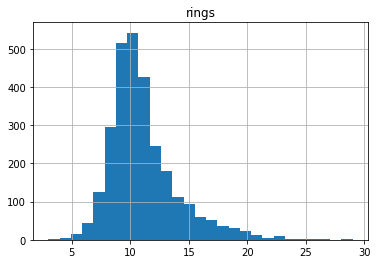

In [22]:
pd.DataFrame.hist(abalone_data_mf, column="rings", bins=27)
plt.draw()
plt.savefig("rings_hist.png",dpi=100)
plt.show()

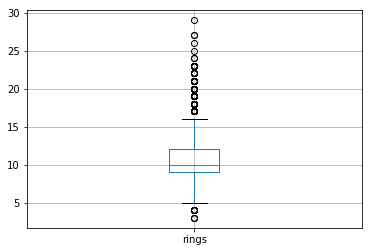

In [23]:
abalone_data_mf.boxplot(column="rings")
plt.savefig("rings_boxplot.png",dpi=100)
plt.show()

In [24]:
#age = ['less_than_11', '11_or_more']
abalone_data_mf['rings'] = pd.cut(abalone_data_mf['rings'], bins=[0,11,30], 
                         right=False, labels=[0, 1])

In [25]:
abalone_data_mf.head()

,length,diameter,height,weight_whole,weight_shucked,weight_viscera,weight_shell,rings
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,0
6,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,1


In [26]:
abalone_data_mf['rings'].value_counts()

0    1543
1    1292
Name: rings, dtype: int64

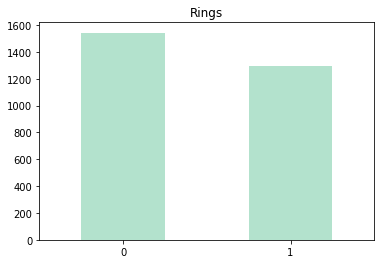

In [27]:
abalone_data_mf['rings'].value_counts().plot(kind='bar', title='Rings', style=None, colormap="Pastel2")
plt.xticks(rotation=0)
plt.savefig("rings_bin.png",dpi=100)
plt.show()

# Alternative classification mehods

In [28]:
#Convert the DataFrame to a numpy array:
train_data = abalone_data_mf.values
train_data

array([[0.455, 0.365, 0.095, ..., 0.10099999999999999, 0.15, 1L],
       [0.35, 0.265, 0.09, ..., 0.0485, 0.07, 0L],
       [0.53, 0.42, 0.135, ..., 0.1415, 0.21, 0L],
       ...,
       [0.6, 0.475, 0.205, ..., 0.2875, 0.308, 0L],
       [0.625, 0.485, 0.15, ..., 0.261, 0.29600000000000004, 0L],
       [0.71, 0.555, 0.195, ..., 0.3765, 0.495, 1L]], dtype=object)

In [29]:
# Training data features, skip the last column 'rings'
train_features = train_data[:, :6]

# 'rings' column values
train_target = train_data[:, 7]
train_target = train_target.astype('int')

In [30]:
train_features[0]

array([0.455, 0.365, 0.095, 0.514, 0.2245, 0.10099999999999999],
      dtype=object)

In [31]:
for i in range(0,5):
    print (train_features[i])

[0.455 0.365 0.095 0.514 0.2245 0.10099999999999999]
[0.35 0.265 0.09 0.2255 0.0995 0.0485]
[0.53 0.42 0.135 0.677 0.2565 0.1415]
[0.44 0.365 0.125 0.516 0.2155 0.114]
[0.53 0.415 0.15 0.7775 0.237 0.1415]


In [32]:
train_target[0]

1

In [33]:
for i in range(0,5):
    print (train_target[i])

1
0
0
0
1


# Decision tree

## Max depth = 5

In [140]:
# Fit the model to our training data
clf = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=5, 
                                  min_samples_split=2, min_samples_leaf=2)
clf = clf.fit(train_features, train_target)

In [141]:
clf.feature_importances_

array([0.00890528, 0.24621015, 0.42132407, 0.13000468, 0.17552557,
       0.01803025])

In [142]:
pred_target = clf.predict(train_features)

print metrics.precision_score(train_target, pred_target, average='weighted')
print metrics.recall_score(train_target, pred_target, average='weighted')
print metrics.f1_score(train_target, pred_target, average='weighted')
print metrics.accuracy_score(train_target, pred_target)
print metrics.precision_recall_fscore_support(train_target, pred_target)

0.7160954759743425
0.7149911816578484
0.7153384953608132
0.7149911816578484
(array([0.7458194 , 0.68059701]), array([0.72261828, 0.70588235]), array([0.73403555, 0.69300912]), array([1543, 1292], dtype=int64))


In [143]:
len(train_data)

2835

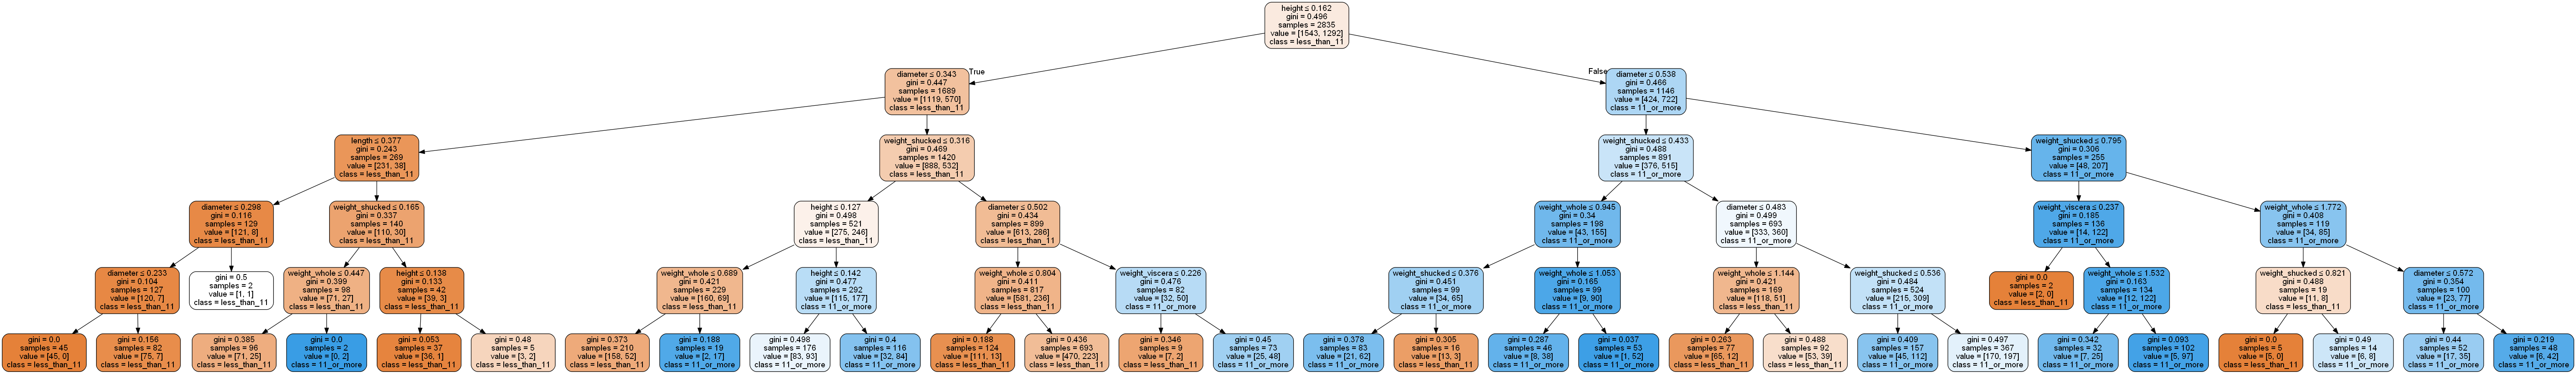

In [144]:
import pydotplus 
from IPython.display import Image  
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=list(abalone_data_mf.columns[:6]),  
                         class_names=['less_than_11', '11_or_more'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [145]:
# Create PDF
graph.write_pdf("dec_tree.pdf")

# Create PNG
graph.write_png("dec_tree.png")

True

In [146]:
cm = confusion_matrix(train_target, pred_target)
print cm

[[1115  428]
 [ 380  912]]


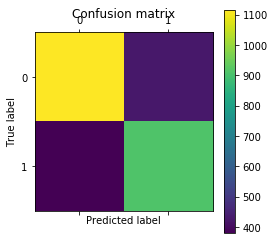

In [147]:
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [148]:
print metrics.accuracy_score(train_target, pred_target)

0.7149911816578484


In [149]:
from sklearn.metrics import classification_report
print(classification_report(train_target, 
                            pred_target, 
                            target_names=['Less than 11', '11 or more']))

              precision    recall  f1-score   support

Less than 11       0.75      0.72      0.73      1543
  11 or more       0.68      0.71      0.69      1292

 avg / total       0.72      0.71      0.72      2835



0.7142503145133622


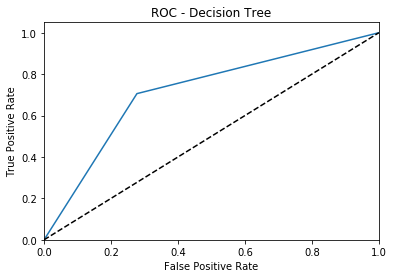

In [152]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(train_target, pred_target)
    roc_auc[i] = auc(fpr[i], tpr[i])

print roc_auc_score(train_target, pred_target)
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Decision Tree')
plt.savefig("ROC_decision_tree.png",dpi=100)
plt.show()

In [153]:
# cross validation
scores = cross_validation.cross_val_score(clf, train_features, train_target, cv=10)
print 'Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2)

Accuracy: 0.67 (+/- 0.08)


In [154]:
# Cross Validation
predictions_decision_tree_CV = cross_validation.cross_val_predict(clf, train_features, train_target, cv=10)

0.6708788215630762


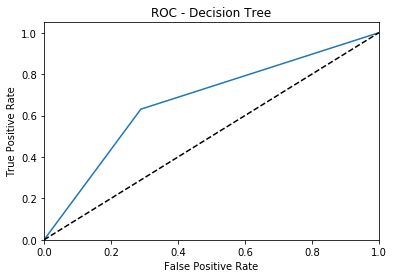

In [155]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(train_target, predictions_decision_tree_CV)
    roc_auc[i] = auc(fpr[i], tpr[i])

print roc_auc_score(train_target, predictions_decision_tree_CV)
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Decision Tree')
plt.savefig("ROC_decision_tree2.png",dpi=100)
plt.show()

# Random Forest

In [156]:
# Random Forest

clf = RandomForestClassifier(n_estimators=50, 
                             criterion='gini',
                             max_features=None,
                             max_depth=None, 
                             min_samples_split=2,
                             min_samples_leaf=5,
                             bootstrap=True,
                             oob_score=False,
                             random_state=None,
                             class_weight=None) #balanced
scores = cross_validation.cross_val_score(clf, train_features, train_target, cv=10)
print 'Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2)

Accuracy: 0.71 (+/- 0.08)


In [157]:
# Cross Validation
predictions_random_forest_CV = cross_validation.cross_val_predict(clf, train_features, train_target, cv=10)

0.7158632614283221


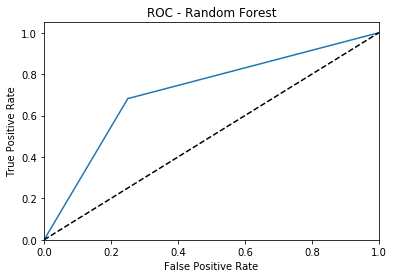

In [158]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(train_target, predictions_random_forest_CV)
    roc_auc[i] = auc(fpr[i], tpr[i])

print roc_auc_score(train_target, predictions_random_forest_CV)
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Random Forest')
plt.savefig("ROC_random_forest.png",dpi=100)
plt.show()

In [159]:
# Random Forest 2

clf = RandomForestClassifier(n_estimators=50, 
                             criterion='entropy',
                             max_features=None,
                             max_depth=None, 
                             min_samples_split=2,
                             min_samples_leaf=5,
                             bootstrap=True,
                             oob_score=False,
                             random_state=None,
                             class_weight=None) #balanced
scores = cross_validation.cross_val_score(clf, train_features, train_target, cv=10)
print 'Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2)

Accuracy: 0.71 (+/- 0.07)


In [160]:
# Cross Validation
predictions_random_forest2_CV = cross_validation.cross_val_predict(clf, train_features, train_target, cv=10)

0.7180686170842454


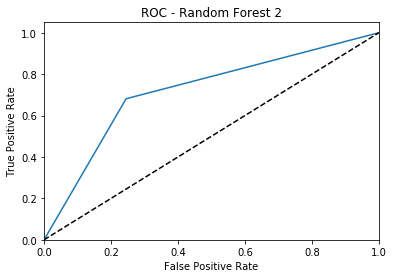

In [161]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(train_target, predictions_random_forest2_CV)
    roc_auc[i] = auc(fpr[i], tpr[i])

print roc_auc_score(train_target, predictions_random_forest2_CV)
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Random Forest 2')
plt.savefig("ROC_random_forest2.png",dpi=100)
plt.show()

# K-NN

In [162]:
n_neighbors = 3
weights = 'uniform'
clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights, metric='euclidean')

In [163]:
clf.fit(train_features, train_target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [164]:
for i in range(10):
    p = clf.predict(train_features[i].reshape(1, -1))
    print i, ":", train_features[i], "predicted: ", p[0], " real: ", train_target[i]

0 : [0.455 0.365 0.095 0.514 0.2245 0.10099999999999999] predicted:  0  real:  1
1 : [0.35 0.265 0.09 0.2255 0.0995 0.0485] predicted:  0  real:  0
2 : [0.53 0.42 0.135 0.677 0.2565 0.1415] predicted:  1  real:  0
3 : [0.44 0.365 0.125 0.516 0.2155 0.114] predicted:  0  real:  0
4 : [0.53 0.415 0.15 0.7775 0.237 0.1415] predicted:  1  real:  1
5 : [0.545 0.425 0.125 0.768 0.294 0.1495] predicted:  1  real:  1
6 : [0.475 0.37 0.125 0.5095 0.2165 0.1125] predicted:  0  real:  0
7 : [0.55 0.44 0.15 0.8945 0.3145 0.151] predicted:  1  real:  1
8 : [0.525 0.38 0.14 0.6065 0.19399999999999998 0.1475] predicted:  1  real:  1
9 : [0.43 0.35 0.11 0.406 0.1675 0.081] predicted:  0  real:  0


In [165]:
from __future__ import division

error = 0
targets = train_target
predictions_KNN = clf.predict(train_features)
num_rows = len(train_target)
for i in range (0, num_rows):
    if predictions_KNN[i] != targets[i]:
        error += 1

print 'error: ', error/num_rows
print 'accuracy: ', 1-error/num_rows

error:  0.166490299824
accuracy:  0.833509700176


In [166]:
for k in range (1, 54, 2):
    lf = neighbors.KNeighborsClassifier(k, weights='uniform')
    scores = cross_validation.cross_val_score(lf, train_features, train_target, cv=10)
    print 'K: ', k, 'Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2)

K:  1 Accuracy: 0.64 (+/- 0.04)
K:  3 Accuracy: 0.67 (+/- 0.07)
K:  5 Accuracy: 0.69 (+/- 0.05)
K:  7 Accuracy: 0.69 (+/- 0.06)
K:  9 Accuracy: 0.70 (+/- 0.07)
K:  11 Accuracy: 0.70 (+/- 0.06)
K:  13 Accuracy: 0.71 (+/- 0.07)
K:  15 Accuracy: 0.71 (+/- 0.07)
K:  17 Accuracy: 0.71 (+/- 0.07)
K:  19 Accuracy: 0.71 (+/- 0.07)
K:  21 Accuracy: 0.71 (+/- 0.08)
K:  23 Accuracy: 0.71 (+/- 0.08)
K:  25 Accuracy: 0.72 (+/- 0.08)
K:  27 Accuracy: 0.71 (+/- 0.08)
K:  29 Accuracy: 0.71 (+/- 0.08)
K:  31 Accuracy: 0.71 (+/- 0.08)
K:  33 Accuracy: 0.72 (+/- 0.08)
K:  35 Accuracy: 0.72 (+/- 0.08)
K:  37 Accuracy: 0.72 (+/- 0.08)
K:  39 Accuracy: 0.72 (+/- 0.08)
K:  41 Accuracy: 0.72 (+/- 0.07)
K:  43 Accuracy: 0.72 (+/- 0.08)
K:  45 Accuracy: 0.72 (+/- 0.08)
K:  47 Accuracy: 0.73 (+/- 0.07)
K:  49 Accuracy: 0.72 (+/- 0.07)
K:  51 Accuracy: 0.72 (+/- 0.07)
K:  53 Accuracy: 0.72 (+/- 0.08)


0.8304316507788092


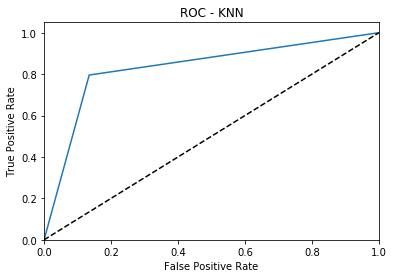

In [167]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(targets, predictions_KNN)
    roc_auc[i] = auc(fpr[i], tpr[i])

print roc_auc_score(targets, predictions_KNN)
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - KNN')
plt.savefig("ROC_knn.png",dpi=100)
plt.show()

In [168]:
# Cross Validation
predictions_KNN_CV = cross_validation.cross_val_predict(clf, train_features, train_target, cv=10)
scores = cross_validation.cross_val_score(clf, train_features, train_target, cv=10)
print 'Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2)

Accuracy: 0.67 (+/- 0.07)


0.6688364911745645


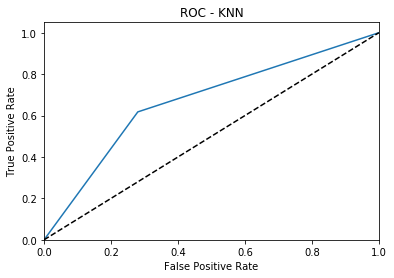

In [169]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(targets, predictions_KNN_CV)
    roc_auc[i] = auc(fpr[i], tpr[i])

print roc_auc_score(targets, predictions_KNN_CV)
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - KNN')
plt.savefig("ROC_knn2.png",dpi=100)
plt.show()

In [170]:
print "error: ", sum(abs(np.array(clf.predict(train_features)) - np.array(train_target)))

error:  472


# Naive Bayes

In [171]:
# Gaussian NB, for normally distributed numerical values  --> more generally applicable
gnb = GaussianNB()
gnb.fit(train_features, train_target)

# Multinomial NB, for discrete labels (yet still numerical)
three_discrete_vars = train_features[:,[0,2,3]]
mnb = MultinomialNB()
mnb.fit(three_discrete_vars, train_target)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [172]:
for i in range(10):
    p = gnb.predict(train_features[i].reshape(1, -1))
    print i, ":", train_features[i], "predicted: ", p[0], " real: ", train_target[i]
print "error: ", sum(abs(np.array(gnb.predict(train_features)) - np.array(train_target)))

0 : [0.455 0.365 0.095 0.514 0.2245 0.10099999999999999] predicted:  0  real:  1
1 : [0.35 0.265 0.09 0.2255 0.0995 0.0485] predicted:  0  real:  0
2 : [0.53 0.42 0.135 0.677 0.2565 0.1415] predicted:  0  real:  0
3 : [0.44 0.365 0.125 0.516 0.2155 0.114] predicted:  0  real:  0
4 : [0.53 0.415 0.15 0.7775 0.237 0.1415] predicted:  0  real:  1
5 : [0.545 0.425 0.125 0.768 0.294 0.1495] predicted:  0  real:  1
6 : [0.475 0.37 0.125 0.5095 0.2165 0.1125] predicted:  0  real:  0
7 : [0.55 0.44 0.15 0.8945 0.3145 0.151] predicted:  0  real:  1
8 : [0.525 0.38 0.14 0.6065 0.19399999999999998 0.1475] predicted:  0  real:  1
9 : [0.43 0.35 0.11 0.406 0.1675 0.081] predicted:  0  real:  0
error:  1153


In [173]:
for i in range(10):
    p = mnb.predict(three_discrete_vars[i].reshape(1, -1))
    print i, ":", three_discrete_vars[i], "predicted: ", p[0], " real: ", train_target[i]
print "error: ", sum(abs(np.array(mnb.predict(three_discrete_vars)) - np.array(train_target)))

0 : [0.455 0.095 0.514] predicted:  0  real:  1
1 : [0.35 0.09 0.2255] predicted:  0  real:  0
2 : [0.53 0.135 0.677] predicted:  0  real:  0
3 : [0.44 0.125 0.516] predicted:  0  real:  0
4 : [0.53 0.15 0.7775] predicted:  0  real:  1
5 : [0.545 0.125 0.768] predicted:  0  real:  1
6 : [0.475 0.125 0.5095] predicted:  0  real:  0
7 : [0.55 0.15 0.8945] predicted:  0  real:  1
8 : [0.525 0.14 0.6065] predicted:  0  real:  1
9 : [0.43 0.11 0.406] predicted:  0  real:  0
error:  1292


In [174]:
error = 0
targets = train_target
predictions_GNB = gnb.predict(train_features)
num_rows = len(train_target)
for i in range (0, num_rows):
    if predictions_GNB[i] != targets[i]:
        error += 1
print "error: ", error/num_rows
print 'accuracy: ', 1-error/num_rows

error:  0.406701940035
accuracy:  0.593298059965


0.5971041194729418


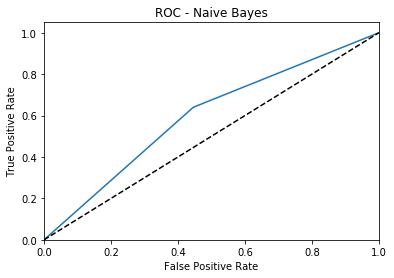

In [175]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(train_target, predictions_GNB)
    roc_auc[i] = auc(fpr[i], tpr[i])

print roc_auc_score(targets, predictions_GNB)
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Naive Bayes')
plt.savefig("ROC_naive_bayes.png",dpi=100)
plt.show()

In [176]:
scores = cross_validation.cross_val_score(gnb, train_features, train_target, cv=10)
print 'Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2)

Accuracy: 0.58 (+/- 0.25)


In [177]:
# Cross Validation
predictions_naive_bayes_CV = cross_validation.cross_val_predict(clf, train_features, train_target, cv=10)

0.6688364911745645


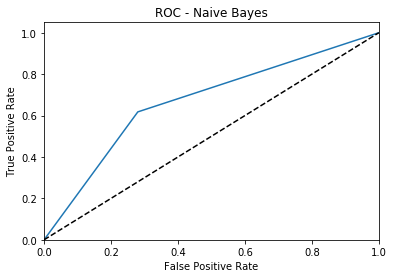

In [178]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(train_target, predictions_GNB_CV)
    roc_auc[i] = auc(fpr[i], tpr[i])

print roc_auc_score(targets, predictions_GNB_CV)
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Naive Bayes')
plt.savefig("ROC_naive_bayes2.png",dpi=100)
plt.show()

# Neural Networks

In [179]:
#
# Neural Networks
#
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(train_features, train_target)  

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [180]:
print "error: ", sum(abs(np.array(clf.predict(train_features)) - np.array(train_target)))

error:  734


In [181]:
# weights of the network
clf.coefs_

[array([[-1.64885943, -0.05163008,  0.962059  , -0.2024004 , -0.59950948],
        [-1.53732105, -0.75094942, -0.83523267, -0.17179341, -2.34573002],
        [-0.25344136,  0.24101398, -1.62270468,  0.83995809, -1.78127011],
        [ 0.48567437, -0.46490119, -4.67834855, -1.13037553, -2.99995793],
        [-1.98321643,  0.38081563, 12.0232975 ,  0.30817523,  6.1776466 ],
        [ 0.3513362 , -0.68274737,  1.55449873, -0.74510251,  2.50286675]]),
 array([[-3.10935273, -1.35495903],
        [ 0.41931341, -0.9009195 ],
        [ 1.98704254,  1.39664648],
        [ 0.79217428, -1.14735548],
        [ 7.09398227, -0.58568103]]),
 array([[-0.51993632],
        [ 2.14902698]])]

In [182]:
error = 0
targets = train_target
predictions_NN = clf.predict(train_features)
num_rows = len(train_target)
for i in range (0, num_rows):
    if predictions_NN[i] != targets[i]:
        error += 1

print 'error: ', error/num_rows
print 'accuracy: ', 1-error/num_rows

error:  0.258906525573
accuracy:  0.741093474427


0.7366557548421013


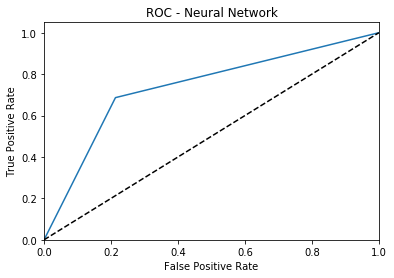

In [183]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(targets, predictions_NN)
    roc_auc[i] = auc(fpr[i], tpr[i])

print roc_auc_score(targets, predictions_NN)
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Neural Network')
plt.savefig('ROC_nn.png',dpi=100)
plt.show()

In [184]:
scores = cross_validation.cross_val_score(clf, train_features, train_target, cv=10)
print 'Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2)

Accuracy: 0.73 (+/- 0.10)


In [185]:
# Cross Validation
predictions_NN_CV = cross_validation.cross_val_predict(clf, train_features, train_target, cv=10)
scores = cross_validation.cross_val_score(clf, train_features, train_target, cv=10)
print 'Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2)

Accuracy: 0.73 (+/- 0.10)


0.7186299256203488


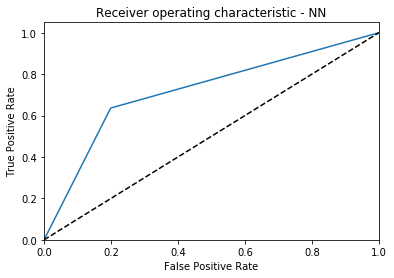

In [186]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(targets, predictions_NN_CV)
    roc_auc[i] = auc(fpr[i], tpr[i])

print roc_auc_score(targets, predictions_NN_CV)
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - NN')
plt.show()

# Model comparison

AUC Decision Tree:  0.6708788215630762
AUC Random Forest:  0.7158632614283221
AUC Naive Bayes:  0.6688364911745645
AUC Neural Network:  0.7186299256203488


<Figure size 432x288 with 0 Axes>

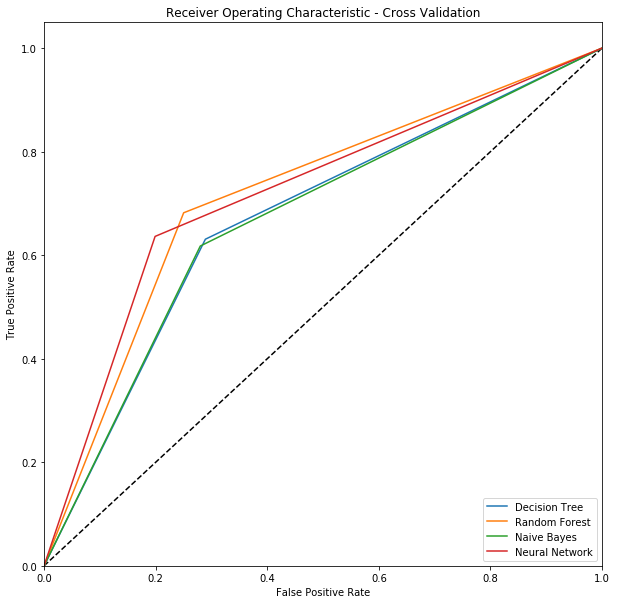

In [201]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

plt.figure()
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Cross Validation')

# decision tree
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(train_target, predictions_decision_tree_CV)
    roc_auc[i] = auc(fpr[i], tpr[i])

print "AUC Decision Tree: ", roc_auc_score(targets, predictions_decision_tree_CV)
plt.plot(fpr[1], tpr[1], label = "Decision Tree")

# random forest
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(train_target, predictions_random_forest_CV)
    roc_auc[i] = auc(fpr[i], tpr[i])

print "AUC Random Forest: ", roc_auc_score(targets, predictions_random_forest_CV)
plt.plot(fpr[1], tpr[1], label = "Random Forest")


# K-NN
#fpr = dict()
#tpr = dict()
#roc_auc = dict()
#for i in range(2):
#    fpr[i], tpr[i], _ = roc_curve(train_target, predictions_KNN_CV)
#    roc_auc[i] = auc(fpr[i], tpr[i])
#
#print "AUC KNN: ", roc_auc_score(targets, predictions_KNN_CV)
#plt.plot(fpr[1], tpr[1], label = "K-NN")


#Naive Bayes
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(train_target, predictions_GNB_CV)
    roc_auc[i] = auc(fpr[i], tpr[i])

print "AUC Naive Bayes: ", roc_auc_score(targets, predictions_GNB_CV)
plt.plot(fpr[1], tpr[1], label = "Naive Bayes")

# Neural Network
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(train_target, predictions_NN_CV)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
print "AUC Neural Network: ", roc_auc_score(targets, predictions_NN_CV)   
plt.plot(fpr[1], tpr[1], label = "Neural Network")


plt.legend(loc="lower right")
plt.savefig("roc_curves.png",dpi=100)
plt.show()